In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU
from keras.layers import LSTM, Reshape, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

import numpy as np
import os
from mido import MidiFile, MidiTrack, Message
import mido

from random import randrange
import NoteBins

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [106]:
paths = []
songs = []
for r, d, f in os.walk(r"C:\Users\Vee\Desktop\python\classical"):
    for file in f:
        if '.mid' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    mid = MidiFile(path, type = 1)
    songs.append(mid)

In [107]:
notes = []
dataset = []
fuckboy = []

In [108]:
#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append([NoteBins.note_reg(msg.note)/11])
    for i in range(1, len(notes)):
        fuckboy.append(notes[i])
        if (i % 16 == 0):
            dataset.append(fuckboy)
            fuckboy = []
    fuckboy = []
    notes = []

In [109]:
dataset = np.array(dataset)
dataset.shape
np.save('answers', dataset) 

In [110]:
bruv = []
#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append([NoteBins.note_reg(msg.note)/11])
    for i in range(1, len(notes)):
        fuckboy.append(notes[i])
        if (i % 16 == 0):
            bruv.append(fuckboy[0:4])
            fuckboy = []
    fuckboy = []
    notes = []

In [111]:
bruv = np.array(bruv)
bruv.shape
np.save('q', bruv) 

In [112]:
#splitting data into train and test sets. 3/4 train, 1/4 test.
x_train,x_test,y_train,y_test = train_test_split(bruv, dataset, test_size=0.4, shuffle=False, random_state=42)

In [113]:
# define model
model = Sequential()
#shaping input to match data
model.add(LSTM(128, input_shape=(4, 1)))
#specifying output to have 40 timesteps
model.add(RepeatVector(16))
#specifying 1 feature as the output
model.add(LSTM(256, activation = 'relu', return_sequences=True, dropout = 0.2))
model.add(LSTM(256, activation = 'relu', return_sequences=True, dropout = 0.2))
model.add(LSTM(256, activation = 'tanh', return_sequences=True, dropout = 0.2))
model.add(TimeDistributed(Dense(512, activation = 'selu')))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(512, activation = 'selu')))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(512, activation = 'relu')))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1, activation = 'linear')))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 128)               66560     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 16, 128)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 16, 256)           394240    
_________________________________________________________________
lstm_30 (LSTM)               (None, 16, 256)           525312    
_________________________________________________________________
lstm_31 (LSTM)               (None, 16, 256)           525312    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 512)           131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 512)          

In [114]:
history = model.fit(x_train, y_train, epochs=20, batch_size=1000, verbose=1,validation_data=(x_test, y_test))

Train on 20056 samples, validate on 13371 samples
Epoch 1/20
20056/20056 [==============================] - 5s 240us/step - loss: 0.1597 - val_loss: 0.1040
Epoch 2/20
20056/20056 [==============================] - 3s 135us/step - loss: 0.1013 - val_loss: 0.0977
Epoch 3/20
20056/20056 [==============================] - 3s 134us/step - loss: 0.0997 - val_loss: 0.0967
Epoch 4/20
20056/20056 [==============================] - 3s 134us/step - loss: 0.0987 - val_loss: 0.0957
Epoch 5/20
20056/20056 [==============================] - 3s 136us/step - loss: 0.0975 - val_loss: 0.0946
Epoch 6/20
20056/20056 [==============================] - 3s 136us/step - loss: 0.0965 - val_loss: 0.0937
Epoch 7/20
20056/20056 [==============================] - 3s 135us/step - loss: 0.0946 - val_loss: 0.0910
Epoch 8/20
20056/20056 [==============================] - 3s 136us/step - loss: 0.0924 - val_loss: 0.0892
Epoch 9/20
20056/20056 [==============================] - 3s 135us/step - loss: 0.0910 - val_loss: 0.0

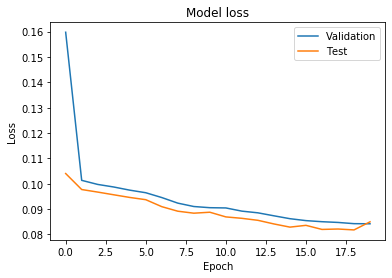

In [115]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Test'], loc='upper right')
plt.show()

In [134]:
j = 0
fuckie = [[[randrange(-1000,1000)], [randrange(-1000,1000)], [randrange(-1000,1000)], [randrange(-1000,1000)]]]
fuckie = np.array(fuckie)
fuckie.reshape(1,4,1)

jamie = model.predict_on_batch(fuckie)
#adjusting from normalization
for x in range(12):
    jamie[0][x][0] = abs(jamie[0][x][0] * 11)
    while(jamie[0][x][0] > 127):
        jamie[0][x][0] = jamie[0][x][0] / 10

In [135]:
timing = np.load('csp.npy',allow_pickle=True)
count = 0
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track2 = MidiTrack()
mid.tracks.append(track2)
track3 = MidiTrack()
mid.tracks.append(track3)
track4 = MidiTrack()
mid.tracks.append(track4)
octave = 12 * 5
t = randrange(len(timing))

track.append(Message('program_change', program=2,time=0))
track2.append(Message('program_change', program=0, time=0))
    
for i in range(2):
    track2.append(Message('note_on', note= 48, velocity=64, time=0))
    track2.append(Message('note_off', note= 48, velocity=64, time=1920))
    track3.append(Message('note_on', note= 50, velocity=64, time=0))
    track3.append(Message('note_off', note= 50, velocity=64, time=1920))
    track4.append(Message('note_on', note= 52, velocity=64, time=0))
    track4.append(Message('note_off', note=52, velocity=64, time=1920))

    track2.append(Message('note_on', note= 47, velocity=64, time=0))
    track2.append(Message('note_off', note= 47, velocity=64, time=1920))
    track3.append(Message('note_on', note= 48, velocity=64, time=0))
    track3.append(Message('note_off', note= 48, velocity=64, time=1920))
    track4.append(Message('note_on', note= 50, velocity=64, time=0))
    track4.append(Message('note_off', note=50, velocity=64, time=1920))

    track2.append(Message('note_on', note= 45, velocity=64, time=0))
    track2.append(Message('note_off', note= 45, velocity=64, time=1920))
    track3.append(Message('note_on', note= 47, velocity=64, time=0))
    track3.append(Message('note_off', note= 47, velocity=64, time=1920))
    track4.append(Message('note_on', note= 48, velocity=64, time=0))
    track4.append(Message('note_off', note=48, velocity=64, time=1920))

    track2.append(Message('note_on', note= 43, velocity=64, time=0))
    track2.append(Message('note_off', note= 43, velocity=64, time=1920))
    track3.append(Message('note_on', note= 45, velocity=64, time=0))
    track3.append(Message('note_off', note= 45, velocity=64, time=1920))
    track4.append(Message('note_on', note= 47, velocity=64, time=0))
    track4.append(Message('note_off', note=47, velocity=64, time=1920))
for x in range(5):
    for i in range(12):
        if(count > 31):
            break
        if(i == 0):
            track.append(Message('note_on', note= octave + NoteBins.note_reg(int(jamie[0][i][0])), velocity=64, time=0))
        else:
            track.append(Message('note_on', note= octave + NoteBins.note_reg(int(jamie[0][i][0])), velocity=64, time=20))
        track.append(Message('note_off', note= octave + NoteBins.note_reg(int(jamie[0][i][0])), velocity=64, time=timing[t].get(str(i))))
        count = count + 1
mid.save('jek.mid')

In [78]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('cc.h5')

In [39]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("all.tflite", "wb").write(tflite_model)

AttributeError: type object 'TFLiteConverter' has no attribute 'from_keras_model'

In [ ]:
import tensorflow as tf
tf.__version__

In [61]:
predict = model.predict(bruv)

In [62]:
#adjusting from normalization
for y in range(len(songs)):
    for x in range(15):
            predict[y][x][0] = predict[y][x][0] * 11
            while(predict[y][x][0] > 127):
                predict[y][x][0] = predict[y][x][0] / 10

In [65]:
for z in range(1500,1524):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track2 = MidiTrack()
    mid.tracks.append(track2)
    track3 = MidiTrack()
    mid.tracks.append(track3)
    track4 = MidiTrack()
    mid.tracks.append(track4)
    octave = 12 * 5
    t = randrange(len(timing))

    track.append(Message('program_change', program=2,time=0))
    track2.append(Message('program_change', program=0, time=0))
    
    for i in range(2):
        track2.append(Message('note_on', note= 48, velocity=64, time=0))
        track2.append(Message('note_off', note= 48, velocity=64, time=1920))
        track3.append(Message('note_on', note= 50, velocity=64, time=0))
        track3.append(Message('note_off', note= 50, velocity=64, time=1920))
        track4.append(Message('note_on', note= 52, velocity=64, time=0))
        track4.append(Message('note_off', note=52, velocity=64, time=1920))

        track2.append(Message('note_on', note= 47, velocity=64, time=0))
        track2.append(Message('note_off', note= 47, velocity=64, time=1920))
        track3.append(Message('note_on', note= 48, velocity=64, time=0))
        track3.append(Message('note_off', note= 48, velocity=64, time=1920))
        track4.append(Message('note_on', note= 50, velocity=64, time=0))
        track4.append(Message('note_off', note=50, velocity=64, time=1920))

        track2.append(Message('note_on', note= 45, velocity=64, time=0))
        track2.append(Message('note_off', note= 45, velocity=64, time=1920))
        track3.append(Message('note_on', note= 47, velocity=64, time=0))
        track3.append(Message('note_off', note= 47, velocity=64, time=1920))
        track4.append(Message('note_on', note= 48, velocity=64, time=0))
        track4.append(Message('note_off', note=48, velocity=64, time=1920))

        track2.append(Message('note_on', note= 43, velocity=64, time=0))
        track2.append(Message('note_off', note= 43, velocity=64, time=1920))
        track3.append(Message('note_on', note= 45, velocity=64, time=0))
        track3.append(Message('note_off', note= 45, velocity=64, time=1920))
        track4.append(Message('note_on', note= 47, velocity=64, time=0))
        track4.append(Message('note_off', note=47, velocity=64, time=1920))
    for x in range(3):
        for i in range(12):
            track.append(Message('note_on', note= octave + NoteBins.note_reg(int(predict[z][i][0])), velocity=64, time=20))
            track.append(Message('note_off', note= octave + NoteBins.note_reg(int(predict[z][i][0])), velocity=64, time=timing[t].get(str(i))))
    mid.save('test' + str(z) + '.mid')

In [64]:
predict

array([[[5.620357  ],
        [5.600093  ],
        [5.56239   ],
        ...,
        [5.4134326 ],
        [5.4159575 ],
        [0.4930788 ]],

       [[5.6203566 ],
        [5.600094  ],
        [5.562388  ],
        ...,
        [5.413438  ],
        [5.415968  ],
        [0.4930799 ]],

       [[5.620356  ],
        [5.600092  ],
        [5.5623827 ],
        ...,
        [5.4134274 ],
        [5.4159474 ],
        [0.49307746]],

       ...,

       [[0.51094157],
        [0.50909966],
        [0.50567216],
        ...,
        [0.49213105],
        [0.4923614 ],
        [0.49308082]],

       [[0.5109415 ],
        [0.5090991 ],
        [0.5056712 ],
        ...,
        [0.4921301 ],
        [0.49235952],
        [0.49307835]],

       [[0.5109415 ],
        [0.50909925],
        [0.5056713 ],
        ...,
        [0.49213016],
        [0.49235964],
        [0.4930785 ]]], dtype=float32)